<b>Problem Statement<b>

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. The objective is to predict whether or not a DonorsChoose.org
project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school.<br><br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score
from prettytable import PrettyTable

<b>Note: If you do not have prettytable module install it first by :
pip install PrettyTable<b>

In [2]:
df = pd.read_csv('Preprocessed_DonorsChoose_dataset.csv')

In [3]:
df.head(3)

,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,cleaned_titles,cleaned_essays,cleaned_summary,isdigit_summary
0,p253737,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,154.60,23,educational support english learners home,students english learners working english seco...,students_need_opportunities_practice_beginning...,0
1,p258326,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,299.00,1,wanted projector hungry learners,students arrive school eager learn polite gene...,students_need_projector_help_viewing_education...,0
2,p182444,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,516.85,22,soccer equipment awesome middle school students,true champions not always ones win guts mia ha...,students_need_shine_guards_athletic_socks_socc...,0


In [4]:
df.isnull().sum()

id                                               0
teacher_prefix                                   0
school_state                                     0
project_grade_category                           0
project_subject_categories                       0
project_subject_subcategories                    0
teacher_number_of_previously_posted_projects     0
project_is_approved                              0
price                                            0
quantity                                         0
cleaned_titles                                  43
cleaned_essays                                   0
cleaned_summary                                  0
isdigit_summary                                  0
dtype: int64

In [5]:
df.shape

(109248, 14)

Since we have sufficient no. of data, droping 43 rows with null values for cleaned_titles

In [6]:
df = df.dropna()

In [7]:
df.shape

(109205, 14)

In [8]:
df.nunique()

id                                              109205
teacher_prefix                                       5
school_state                                        51
project_grade_category                               4
project_subject_categories                          51
project_subject_subcategories                      401
teacher_number_of_previously_posted_projects       374
project_is_approved                                  2
price                                            45231
quantity                                           332
cleaned_titles                                   91442
cleaned_essays                                  108272
cleaned_summary                                 107844
isdigit_summary                                      2
dtype: int64

<b>Analysis of teacher_prefix w.r.t % projects approved<b>

In [12]:
teacher_approved_count = df.loc[df['project_is_approved']==1,'teacher_prefix'].value_counts()
teacher_approved_count_percent = np.round((teacher_approved_count / teacher_approved_count.sum() * 100) , 2)

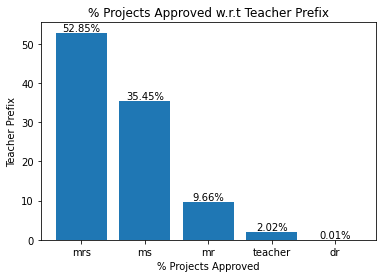

In [13]:
project_ticks_teacher = [f"{a}%" for a in teacher_approved_count_percent.values]
fig, ax = plt.subplots()
g=ax.bar(teacher_approved_count_percent.index, teacher_approved_count_percent.values)
ax.set_xlabel("% Projects Approved")
ax.set_ylabel("Teacher Prefix")
ax.set_title("% Projects Approved w.r.t Teacher Prefix")
ax.bar_label(g, labels=project_ticks_teacher)
plt.show()

Observation: Close to 90% of approved projects have lady teacher while all remaining prefixes consist fo about 10% approved projects.

<b>Analysis of school_state w.r.t % projects approved<b>

In [14]:
school_state_approved_count = df.loc[df['project_is_approved']==1,'school_state'].value_counts()
school_state_approved_count_percent = np.round((school_state_approved_count / school_state_approved_count.sum() * 100), 2)

<b style="color:red;">Note : ax.bar_label - this is only available at higher version of matplotlib, 3.4.2 and above. Please Make sure you have it.<b>

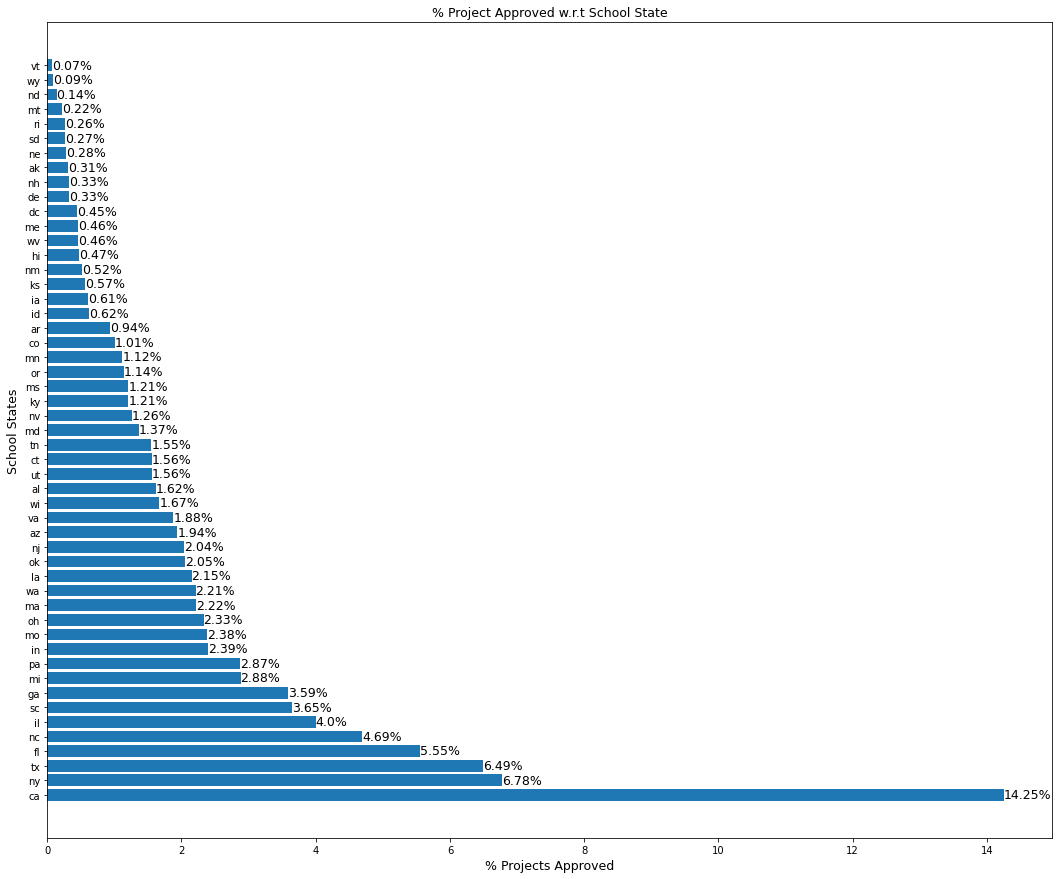

In [18]:
project_ticks_state = [f"{a}%" for a in school_state_approved_count_percent.values]
fig, ax = plt.subplots(figsize=(18,15))
g=ax.barh(school_state_approved_count_percent.index, school_state_approved_count_percent.values)
ax.set_xlabel("% Projects Approved", fontsize=12.5)
ax.set_ylabel("School States", fontsize=12.5)
ax.set_title("% Project Approved w.r.t School State", fontsize=12.5)
ax.bar_label(g, labels=project_ticks_state, fontsize=12.5)
plt.show()

Observation: states from pa to ca (order as shown in graph) have most of the approved projects coming from, while remaining have more or less same/close to same number of approved projects with vt being lowest in them.

<b>Analysis of price w.r.t % projects approved<b>

In [19]:
prices_for_approved = df.loc[df['project_is_approved']==1,'price']
price_ranges_for_approved_count = pd.cut(
    prices_for_approved,
    bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 10000],
    labels=['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900','900-1000','> 1000']
).value_counts(sort=False)
price_ranges_for_approved_count_percent = np.round((price_ranges_for_approved_count / price_ranges_for_approved_count.sum() * 100), 2)

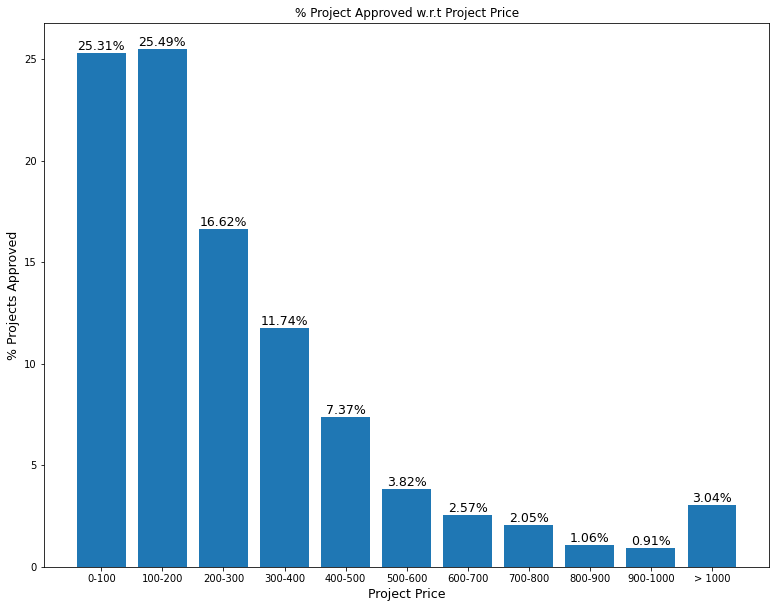

In [20]:
project_ticks_price = [f"{a}%" for a in price_ranges_for_approved_count_percent.values]
fig, ax = plt.subplots(figsize=(13,10))
g=ax.bar(price_ranges_for_approved_count_percent.index, price_ranges_for_approved_count_percent.values)
ax.set_ylabel("% Projects Approved", fontsize=12.5)
ax.set_xlabel("Project Price", fontsize=12.5)
ax.set_title("% Project Approved w.r.t Project Price")
ax.bar_label(g, labels=project_ticks_price, fontsize=12.5)
plt.show()

Observation: More than 60% of approved projects have prices below 300. About 3% lie between large range of 1000 & 10,000. Cheaper projects have better project approval rate based on only this analysis.

<b>Count Plot for % data distribution for each class<b>

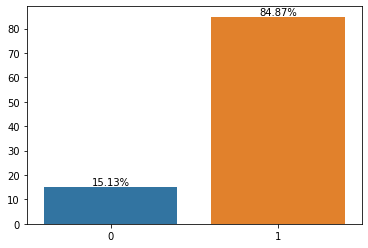

In [21]:
# class frequency
class_distribution_count = df['project_is_approved'].value_counts(sort=False)
# calculate class distribution percentage from frequency
class_distribution_percent = np.round((class_distribution_count / class_distribution_count.sum() * 100) , 2)
# data labels
distribution_percent_ticks = [f"{a}%" for a in class_distribution_percent.values]
# plot class distrbution
ax = sns.barplot(x=class_distribution_percent.index,y=class_distribution_percent.values)
ax.bar_label(ax.containers[0], labels=distribution_percent_ticks)
plt.show()

Observation: There is high class imbalance biased towards 'Approved' (1) class.

<b>Data Preparation<b>

Splitting data into test & train sets (Train:80, Test:20), stratifying split based on target variable

In [22]:
# features data
x = df.iloc[:,:-1]
# target var data
y = df.project_is_approved
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=5, stratify=y)

In [23]:
x_train.shape

(73167, 13)

In [24]:
x_test.shape

(36038, 13)

In [25]:
y_train.shape

(73167,)

In [26]:
y_test.shape

(36038,)

<b>Vectorization of text columns<b>

<b>Case 1 - Bag of Words Vectorization for cleaned_titles & cleaned_essays<b>

cleaned_essays

In [27]:
# considering only the words which appeared in at least 10 rows / projects
vectorizer_essays_bow = CountVectorizer(min_df=10)
# vectorizer will be fit only on train data
vectorizer_essays_bow.fit(x_train.cleaned_essays.values)
# transfrom for test & train
x_train_essays_bow = vectorizer_essays_bow.transform(x_train.cleaned_essays.values)
x_test_essays_bow = vectorizer_essays_bow.transform(x_test.cleaned_essays.values)
print('x_train_essays_bow', x_train_essays_bow.shape)
print('x_test_essays_bow', x_test_essays_bow.shape)

x_train_essays_bow (73167, 14121)
x_test_essays_bow (36038, 14121)


cleaned_titles

In [28]:
# considering only the words which appeared in at least 10 rows / projects
vectorizer_titles_bow = CountVectorizer(min_df=10)
# vectorizer will be fit only on train data
vectorizer_titles_bow.fit(x_train.cleaned_titles.values)
# transfrom for test & train
x_train_titles_bow = vectorizer_titles_bow.transform(x_train.cleaned_titles.values)
x_test_titles_bow = vectorizer_titles_bow.transform(x_test.cleaned_titles.values)
print('x_train_titles_bow', x_train_titles_bow.shape)
print('x_test_titles_bow', x_test_titles_bow.shape)

x_train_titles_bow (73167, 2522)
x_test_titles_bow (36038, 2522)


<b>Case 2 - TFIDF Vectorization for cleaned_titles & cleaned_essays<b>

cleaned_essays

In [29]:
# considering only the words which appeared in at least 10 rows / projects
vectorizer_essays_tfidf = TfidfVectorizer(min_df=10)
# vectorizer will be fit only on train data
vectorizer_essays_tfidf.fit(x_train.cleaned_essays.values)
# transfrom for test & train
x_train_essays_tfidf = vectorizer_essays_tfidf.transform(x_train.cleaned_essays.values)
x_test_essays_tfidf = vectorizer_essays_tfidf.transform(x_test.cleaned_essays.values)
print('x_train_essays_tfidf', x_train_essays_tfidf.shape)
print('x_test_essays_tfidf', x_test_essays_tfidf.shape)

x_train_essays_tfidf (73167, 14121)
x_test_essays_tfidf (36038, 14121)


cleaned_titles

In [30]:
# considering only the words which appeared in at least 10 rows / projects
vectorizer_titles_tfidf = TfidfVectorizer(min_df=10)
# vectorizer will be fit only on train data
vectorizer_titles_tfidf.fit(x_train.cleaned_titles.values)
# transfrom for test & train
x_train_titles_tfidf = vectorizer_titles_tfidf.transform(x_train.cleaned_titles.values)
x_test_titles_tfidf = vectorizer_titles_tfidf.transform(x_test.cleaned_titles.values)
print('x_train_titles_tfidf', x_train_titles_tfidf.shape)
print('x_test_titles_tfidf', x_test_titles_tfidf.shape)

x_train_titles_tfidf (73167, 2522)
x_test_titles_tfidf (36038, 2522)


<b>One Hot Encoding Categorical Variables - teacher_prefix, school_state, project_grade_category, project_subject_categories, project_subject_subcategories<b>

teacher_prefix

In [31]:
# one hot encoding teacher_prefix
vectorizer_teacher_onehot = CountVectorizer(lowercase=False, binary=True)
# fit only on train data
vectorizer_teacher_onehot.fit(x_train.teacher_prefix.values)
# transfrom for test & train
x_train_teacher_onehot = vectorizer_teacher_onehot.transform(x_train.teacher_prefix.values)
x_test_teacher_onehot = vectorizer_teacher_onehot.transform(x_test.teacher_prefix.values)
print('x_train_teacher_onehot', x_train_teacher_onehot.shape)
print('x_test_teacher_onehot', x_test_teacher_onehot.shape)
print(vectorizer_teacher_onehot.get_feature_names())

x_train_teacher_onehot (73167, 5)
x_test_teacher_onehot (36038, 5)
['dr', 'mr', 'mrs', 'ms', 'teacher']


project_grade_category

In [32]:
# one hot encoding project_grade_category
vectorizer_grade_onehot = CountVectorizer(lowercase=False, binary=True)
# fit only on train data
vectorizer_grade_onehot.fit(x_train.project_grade_category.values)
# transfrom for test & train
x_train_grade_onehot = vectorizer_grade_onehot.transform(x_train.project_grade_category.values)
x_test_grade_onehot = vectorizer_grade_onehot.transform(x_test.project_grade_category.values)
print('x_train_grade_onehot', x_train_grade_onehot.shape)
print('x_test_grade_onehot', x_test_grade_onehot.shape)
print(vectorizer_grade_onehot.get_feature_names())

x_train_grade_onehot (73167, 4)
x_test_grade_onehot (36038, 4)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


school_state 

In [33]:
# one hot encoding school_state
vectorizer_school_state_onehot = CountVectorizer(lowercase=False, binary=True)
# fit only on train data
vectorizer_school_state_onehot.fit(x_train.school_state.values)
# transfrom for test & train
x_train_school_state_onehot = vectorizer_school_state_onehot.transform(x_train.school_state.values)
x_test_school_state_onehot = vectorizer_school_state_onehot.transform(x_test.school_state.values)
print('x_train_school_state_onehot', x_train_school_state_onehot.shape)
print('x_test_school_state_onehot', x_test_school_state_onehot.shape)
print(vectorizer_school_state_onehot.get_feature_names())

x_train_school_state_onehot (73167, 51)
x_test_school_state_onehot (36038, 51)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


project_subject_categories 

In [34]:
# one hot encoding project_subject_categories
vectorizer_subject_categories_onehot = CountVectorizer(lowercase=False, binary=True)
# fit only on train data
vectorizer_subject_categories_onehot.fit(x_train.project_subject_categories.values)
# transfrom for test & train
x_train_subject_categories_onehot = vectorizer_subject_categories_onehot.transform(x_train.project_subject_categories.values)
x_test_subject_categories_onehot = vectorizer_subject_categories_onehot.transform(x_test.project_subject_categories.values)
print('x_train_subject_categories_onehot', x_train_subject_categories_onehot.shape)
print('x_test_subject_categories_onehot', x_test_subject_categories_onehot.shape)
print(vectorizer_subject_categories_onehot.get_feature_names())

x_train_subject_categories_onehot (73167, 51)
x_test_subject_categories_onehot (36038, 51)
['appliedlearning', 'appliedlearning_health_sports', 'appliedlearning_history_civics', 'appliedlearning_literacy_language', 'appliedlearning_math_science', 'appliedlearning_music_arts', 'appliedlearning_specialneeds', 'appliedlearning_warmth_care_hunger', 'health_sports', 'health_sports_appliedlearning', 'health_sports_history_civics', 'health_sports_literacy_language', 'health_sports_math_science', 'health_sports_music_arts', 'health_sports_specialneeds', 'health_sports_warmth_care_hunger', 'history_civics', 'history_civics_appliedlearning', 'history_civics_health_sports', 'history_civics_literacy_language', 'history_civics_math_science', 'history_civics_music_arts', 'history_civics_specialneeds', 'history_civics_warmth_care_hunger', 'literacy_language', 'literacy_language_appliedlearning', 'literacy_language_health_sports', 'literacy_language_history_civics', 'literacy_language_math_science', '

project_subject_subcategories 

In [35]:
# one hot encoding project_subject_subcategories
vectorizer_subject_subcategories_onehot = CountVectorizer(lowercase=False, binary=True)
# fit only on train data
vectorizer_subject_subcategories_onehot.fit(x_train.project_subject_subcategories.values)
# transfrom for test & train
x_train_subject_subcategories_onehot = vectorizer_subject_subcategories_onehot.transform(x_train.project_subject_subcategories.values)
x_test_subject_subcategories_onehot = vectorizer_subject_subcategories_onehot.transform(x_test.project_subject_subcategories.values)
print('x_train_subject_subcategories_onehot', x_train_subject_subcategories_onehot.shape)
print('x_test_subject_subcategories_onehot', x_test_subject_subcategories_onehot.shape)
print(vectorizer_subject_subcategories_onehot.get_feature_names())

x_train_subject_subcategories_onehot (73167, 392)
x_test_subject_subcategories_onehot (36038, 392)
['appliedsciences', 'appliedsciences_charactereducation', 'appliedsciences_civics_government', 'appliedsciences_college_careerprep', 'appliedsciences_communityservice', 'appliedsciences_earlydevelopment', 'appliedsciences_economics', 'appliedsciences_environmentalscience', 'appliedsciences_esl', 'appliedsciences_extracurricular', 'appliedsciences_financialliteracy', 'appliedsciences_foreignlanguages', 'appliedsciences_gym_fitness', 'appliedsciences_health_lifescience', 'appliedsciences_health_wellness', 'appliedsciences_history_geography', 'appliedsciences_literacy', 'appliedsciences_literature_writing', 'appliedsciences_mathematics', 'appliedsciences_music', 'appliedsciences_nutritioneducation', 'appliedsciences_other', 'appliedsciences_parentinvolvement', 'appliedsciences_performingarts', 'appliedsciences_socialsciences', 'appliedsciences_specialneeds', 'appliedsciences_teamsports', 'ap

<b>Normalizing numerical variables - price, quantity, teacher_number_of_previously_posted_projects<b>

price

In [36]:
normalizer_price = MinMaxScaler()
# fit on train data
normalizer_price.fit(x_train.price.values.reshape(-1, 1))

# transform on train & test data
x_train_price_normalized = normalizer_price.transform(x_train.price.values.reshape(-1, 1))
x_test_price_normalized = normalizer_price.transform(x_test.price.values.reshape(-1, 1))

print('x_train_price_normalized',x_train_price_normalized.T, x_train_price_normalized.shape)
print('x_test_price_normalized',x_test_price_normalized.T, x_test_price_normalized.shape)

x_train_price_normalized [[1.26621019e-02 1.29341471e-02 1.73378781e-02 ... 4.43173567e-03
  2.49974496e-01 1.67027727e-04]] (73167, 1)
x_test_price_normalized [[0.10191492 0.02779061 0.02421802 ... 0.00093315 0.00911251 0.02693747]] (36038, 1)


quantity

In [37]:
normalizer_quantity = MinMaxScaler()
# fit on train data
normalizer_quantity.fit(x_train.quantity.values.reshape(-1, 1))

# transform on train & test data
x_train_quantity_normalized = normalizer_quantity.transform(x_train.quantity.values.reshape(-1, 1))
x_test_quantity_normalized = normalizer_quantity.transform(x_test.quantity.values.reshape(-1, 1))

print('x_train_quantity_normalized', x_train_quantity_normalized.T, x_train_quantity_normalized.shape)
print('x_test_quantity_normalized', x_test_quantity_normalized.T, x_test_quantity_normalized.shape)

x_train_quantity_normalized [[0.00625782 0.00876095 0.0350438  ... 0.03003755 0.         0.28035044]] (73167, 1)
x_test_quantity_normalized [[0.01501877 0.0387985  0.00500626 ... 0.02377972 0.03128911 0.        ]] (36038, 1)


teacher_number_of_previously_posted_projects

In [38]:
normalizer_teacher_prev_projects = MinMaxScaler()
# fit on train data
normalizer_teacher_prev_projects.fit(x_train.teacher_number_of_previously_posted_projects.values.reshape(-1, 1))

# transform on train & test data
x_train_teacher_prev_projects_normalized = normalizer_teacher_prev_projects.transform(x_train.teacher_number_of_previously_posted_projects.values.reshape(-1, 1))
x_test_teacher_prev_projects_normalized = normalizer_teacher_prev_projects.transform(x_test.teacher_number_of_previously_posted_projects.values.reshape(-1, 1))

print('x_train_teacher_prev_projects_normalized', x_train_teacher_prev_projects_normalized.T, x_train_teacher_prev_projects_normalized.shape)
print('x_test_teacher_prev_projects_normalized', x_test_teacher_prev_projects_normalized.T, x_test_teacher_prev_projects_normalized.shape)

x_train_teacher_prev_projects_normalized [[0.02882483 0.00221729 0.00886918 ... 0.03104213 0.01995565 0.00221729]] (73167, 1)
x_test_teacher_prev_projects_normalized [[0.06430155 0.00665188 0.02439024 ... 0.00443459 0.00665188 0.        ]] (36038, 1)


<b>Concentrating all features for Case 1 (BOW) & Case 2 (TFIDF)<b>

Concentrating all Non-text features

In [39]:
X_train_other = hstack((x_train_quantity_normalized,
                      x_train_teacher_prev_projects_normalized,
                      x_train_price_normalized,
                      x_train_subject_subcategories_onehot,
                      x_train_subject_categories_onehot,
                      x_train_school_state_onehot,
                      x_train_grade_onehot,
                      x_train_teacher_onehot
                     ))

In [40]:
print(type(X_train_other))
print(X_train_other.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(73167, 506)


In [41]:
X_Test_other = hstack((x_test_quantity_normalized,
                      x_test_teacher_prev_projects_normalized,
                      x_test_price_normalized,
                      x_test_subject_subcategories_onehot,
                      x_test_subject_categories_onehot,
                      x_test_school_state_onehot,
                      x_test_grade_onehot,
                      x_test_teacher_onehot
                     ))

In [42]:
print(type(X_Test_other))
print(X_Test_other.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(36038, 506)


Concentrating Non-text features with text features : Case 1 : BOW

In [43]:
X_train_BoW = hstack((X_train_other, x_train_essays_bow, x_train_titles_bow)).tocsr()
X_Test_BoW = hstack((X_Test_other, x_test_essays_bow, x_test_titles_bow)).tocsr()
print('X_train_BoW',type(X_train_BoW),X_train_BoW.shape)
print('X_Test_BoW',type(X_Test_BoW),X_Test_BoW.shape)

X_train_BoW <class 'scipy.sparse.csr.csr_matrix'> (73167, 17149)
X_Test_BoW <class 'scipy.sparse.csr.csr_matrix'> (36038, 17149)


Concentrating Non-text features with text features : Case 2 : TFIDF

In [44]:
X_train_TFIDF = hstack((X_train_other, x_train_essays_tfidf, x_train_titles_tfidf)).tocsr()
X_Test_TFIDF = hstack((X_Test_other, x_test_essays_tfidf, x_test_titles_tfidf)).tocsr()
print('X_train_TFIDF',type(X_train_TFIDF),X_train_TFIDF.shape)
print('X_Test_TFIDF',type(X_Test_TFIDF),X_Test_TFIDF.shape)

X_train_TFIDF <class 'scipy.sparse.csr.csr_matrix'> (73167, 17149)
X_Test_TFIDF <class 'scipy.sparse.csr.csr_matrix'> (36038, 17149)


<b>Model Building : Case 1 : BOW<b>

Finding the best hyper parameters by GridSearchCV - using 3 folds cross-validation

In case of binary classification usually its best to evaluate based on roc scores, so we are using roc_auc as scoring criteria for GridSearchCV

In [46]:
dt_bow = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[5, 10, 50],'min_samples_split':[10, 100, 500]}
grid_search_bow = GridSearchCV(dt_bow, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)

Case 1 : BOW : Fitting model

In [47]:
grid_search_bow.fit(X_train_BoW,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 50],
                         'min_samples_split': [10, 100, 500]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [48]:
print("Best Max Depth:",grid_search_bow.best_params_['max_depth'])
print("Best Min Samples Split:",grid_search_bow.best_params_['min_samples_split'])
print("Best Score:",grid_search_bow.best_score_)

Best Max Depth: 10
Best Min Samples Split: 500
Best Score: 0.6857517547134536


Case 1 : BOW : Build Model using above best hyper parameters & make predictions for train & test Data

In [49]:
# build model using best parameters found by above hyper parameter tuning
dt_bow_testModel = DecisionTreeClassifier(class_weight='balanced',
                                          min_samples_split=grid_search_bow.best_params_['min_samples_split'],
                                          max_depth=grid_search_bow.best_params_['max_depth']
                                         )
dt_bow_testModel.fit(X_train_BoW, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

In [50]:
# prediction for train & test data - bow
y_train_pred_bow= dt_bow_testModel.predict(X_train_BoW)
y_test_pred_bow = dt_bow_testModel.predict(X_Test_BoW)

Case 1 : BOW : Plotting Confusion Matrix & ROC Curve for Train Data

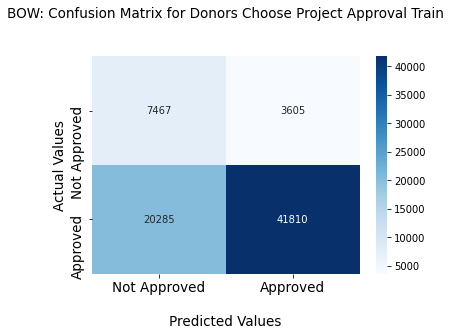

In [81]:
# train data - confusion matrix
cm_train_bow = confusion_matrix(y_train,y_train_pred_bow)

# plot confusion matrix for train data predition for bow
ax = sns.heatmap(cm_train_bow, annot=True, cmap='Blues', fmt='g')
ax.set_title('BOW: Confusion Matrix for Donors Choose Project Approval Train\n\n', fontdict={'size':'13.5'})
ax.set_xlabel('\nPredicted Values', fontdict={'size':'13.5'})
ax.set_ylabel('Actual Values', fontdict={'size':'13.5'})
ax.xaxis.set_ticklabels(['Not Approved','Approved'])
ax.yaxis.set_ticklabels(['Not Approved','Approved'])
ax.tick_params(axis='both', which='major', labelsize=13.5)
plt.show()

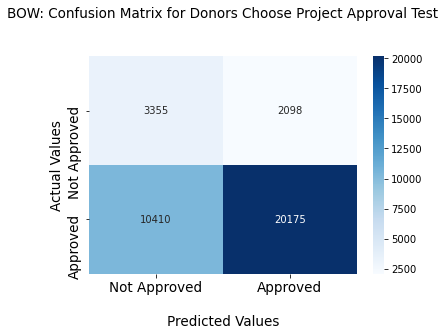

In [78]:
# test data - confusion matrix
cm_test_bow = confusion_matrix(y_test,y_test_pred_bow)

# plot confusion matrix for test data predition for bow
ax = sns.heatmap(cm_test_bow, annot=True, cmap='Blues', fmt='g')
ax.set_title('BOW: Confusion Matrix for Donors Choose Project Approval Test\n\n', fontdict={'size':'13.5'})
ax.set_xlabel('\nPredicted Values', fontdict={'size':'13.5'})
ax.set_ylabel('Actual Values', fontdict={'size':'13.5'})
ax.xaxis.set_ticklabels(['Not Approved','Approved'])
ax.yaxis.set_ticklabels(['Not Approved','Approved'])
ax.tick_params(axis='both', which='major', labelsize=13.5)
plt.show()

In [53]:
# accuracy calculation
train_score_bow = accuracy_score(y_train, y_train_pred_bow)
test_score_bow = accuracy_score(y_test, y_test_pred_bow)
print(train_score_bow, test_score_bow)

0.6734866811540722 0.6529219157555913


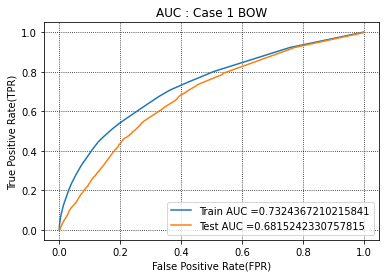

In [54]:
# predicting probabilities for roc curve
y_train_pred_prob_bow= dt_bow_testModel.predict_proba(X_train_BoW)[:,1]
y_test_pred_prob_bow = dt_bow_testModel.predict_proba(X_Test_BoW)[:,1]

train_fpr_bow, train_tpr_bow, train_thresholds_bow = roc_curve(y_train, y_train_pred_prob_bow)
test_fpr_bow, test_tpr_bow, test_thresholds_bow = roc_curve(y_test, y_test_pred_prob_bow)

# plotting roc curve for train & test data
ax = plt.subplot()
ax.plot(train_fpr_bow, train_tpr_bow, label="Train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
ax.plot(test_fpr_bow, test_tpr_bow, label="Test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC : Case 1 BOW")
plt.grid(visible=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

<b>Model Building : Case 2 : TFIDF<b>

Finding the best hyper parameters by GridSearchCV - using 3 folds cross-validation & fitting the Model

In case of binary classification usually its best to evaluate based on roc scores, so  we are using roc_auc as scoring criteria for GridSearchCV

In [55]:
grid_search_tfidf = GridSearchCV(dt, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)
grid_search_tfidf.fit(X_train_TFIDF,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 50],
                         'min_samples_split': [10, 100, 500]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [56]:
print("Best Max Depth:",grid_search_tfidf.best_params_['max_depth'])
print("Best Min Samples Split:",grid_search_tfidf.best_params_['min_samples_split'])
print("Best Score:",grid_search_tfidf.best_score_)

Best Max Depth: 10
Best Min Samples Split: 500
Best Score: 0.6835305361222549


Case 2 : TFIDF : Build Model using above best hyper parameters & make predictions for train & test Data

In [57]:
# build model using best parameters found by above hyper parameter tuning
dt_tfidf_testModel = DecisionTreeClassifier(class_weight='balanced',
                                          min_samples_split=grid_search_tfidf.best_params_['min_samples_split'],
                                          max_depth=grid_search_tfidf.best_params_['max_depth']
                                         )
dt_tfidf_testModel.fit(X_train_TFIDF, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

In [58]:
# prediction for train & test data - tfidf
y_train_pred_tfidf= dt_tfidf_testModel.predict(X_train_TFIDF)
y_test_pred_tfidf = dt_tfidf_testModel.predict(X_Test_TFIDF)

Case 2 : TFIDF : Plotting Confusion Matrix & ROC Curve for Train Data & Getting test,train accuracy scores

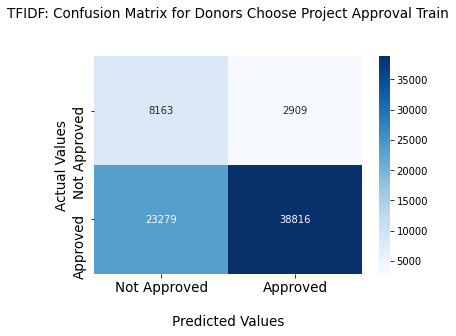

In [79]:
# train data - confusion matrix
cm_train_tfidf = confusion_matrix(y_train, y_train_pred_tfidf)

# plot confusion matrix for train data predition for bow
ax = sns.heatmap(cm_train_tfidf, annot=True, cmap='Blues', fmt='g')
ax.set_title('TFIDF: Confusion Matrix for Donors Choose Project Approval Train\n\n', fontdict={'size':'13.5'})
ax.set_xlabel('\nPredicted Values', fontdict={'size':'13.5'})
ax.set_ylabel('Actual Values', fontdict={'size':'13.5'})
ax.xaxis.set_ticklabels(['Not Approved','Approved'])
ax.yaxis.set_ticklabels(['Not Approved','Approved'])
ax.tick_params(axis='both', which='major', labelsize=13.5)
plt.show()

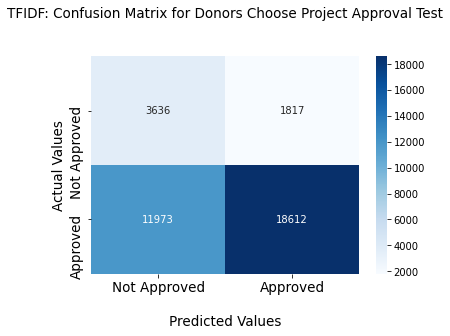

In [80]:
# test data - confusion matrix
cm_test_tfidf = confusion_matrix(y_test, y_test_pred_tfidf)

# plot confusion matrix for train data predition for bow
ax = sns.heatmap(cm_test_tfidf, annot=True, cmap='Blues', fmt='g')
ax.set_title('TFIDF: Confusion Matrix for Donors Choose Project Approval Test\n\n', fontdict={'size':'13.5'})
ax.set_xlabel('\nPredicted Values', fontdict={'size':'13.5'})
ax.set_ylabel('Actual Values', fontdict={'size':'13.5'})
ax.xaxis.set_ticklabels(['Not Approved','Approved'])
ax.yaxis.set_ticklabels(['Not Approved','Approved'])
ax.tick_params(axis='both', which='major', labelsize=13.5)
plt.show()

In [61]:
# accuracy calculation
train_score_tfidf = accuracy_score(y_train, y_train_pred_tfidf)
test_score_tfidf = accuracy_score(y_test, y_test_pred_tfidf)
print(train_score_tfidf, test_score_tfidf)

0.642079079366381 0.617348354514679


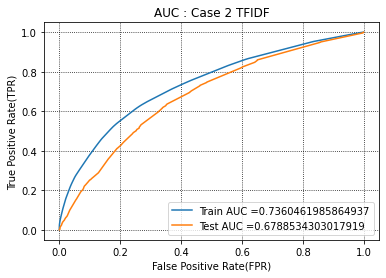

In [62]:
# predicting probabilities for roc curve
y_train_pred_prob_tfidf= dt_tfidf_testModel.predict_proba(X_train_TFIDF)[:,1]
y_test_pred_prob_tfidf = dt_tfidf_testModel.predict_proba(X_Test_TFIDF)[:,1]

train_fpr_tfidf, train_tpr_tfidf, train_thresholds_tfidf = roc_curve(y_train, y_train_pred_prob_tfidf)
test_fpr_tfidf, test_tpr_tfidf, test_thresholds_tfidf = roc_curve(y_test, y_test_pred_prob_tfidf)

# plotting roc curve for train & test data
ax = plt.subplot()
ax.plot(train_fpr_tfidf, train_tpr_tfidf, label="Train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
ax.plot(test_fpr_tfidf, test_tpr_tfidf, label="Test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC : Case 2 TFIDF")
plt.grid(visible=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

<b>Selecting & modeling with features with non-zero feature importance for Case 2 (TFIDF)<b>

In [69]:
# get features importance of all features from tfidf model
features_importance = dt_tfidf_testModel.feature_importances_
nonzero_features_importance = features_importance[features_importance > 0]
# get indices of features with non-zero feature importance
nonzero_features_importance_indices = np.argsort(features_importance)[len(nonzero_features_importance)*(-1):]
print('No of non zero importance features:',len(nonzero_features_importance_indices))
print('Non zero importance features indices:',nonzero_features_importance_indices)

No of non zero importance features: 105
Non zero importance features indices: [  329 13296  9494 16522 10673  5417 16384 10679 12834  9619  7621 14185
 13036  6057 12686  7781 11053   502  1510  8397  6103  6273 11559 13155
  4062  3924   903  1230  5070  1441  5049  9000  8479  4476   871 11246
  7937  4495  7651  1741 11481  3311 12075  6836  2660 11649  1191  9319
  6785  5110 15954  4197  7599 14588 14202  1380  8715  1371 12685   904
 12141  2653  1520  4898 11983  5897 11091 11748  5880 10059  3036 10786
  9209  4368 14474  2860  1750  3081  1925 10210  4330  6455  5238  4666
  7575 12579  8712  5164 11391 10675  1459  8116 12833  2646  7347 13937
  8236 14444  8280 12573  2801  2088     1     0     2]


In [70]:
# selecting data of only non zero importance features from X_train_TFID & X_Test_TFIDF
X_train_TFIDF_nonzero_imp = X_train_TFIDF[:,nonzero_features_importance_indices]
X_Test_TFIDF_nonzero_imp = X_Test_TFIDF[:,nonzero_features_importance_indices]
print(X_train_TFIDF_nonzero_imp.shape)
print(X_Test_TFIDF_nonzero_imp.shape)

(73167, 105)
(36038, 105)


Apply DTC on train & test sets for non zero importance features

Finding best hyperparameters

In [71]:
grid_search_tfidf_nonzero_imp = GridSearchCV(dt, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)
grid_search_tfidf_nonzero_imp.fit(X_train_TFIDF_nonzero_imp,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 50],
                         'min_samples_split': [10, 100, 500]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [72]:
print("Best Max Depth:",grid_search_tfidf_nonzero_imp.best_params_['max_depth'])
print("Best Min Samples Split:",grid_search_tfidf_nonzero_imp.best_params_['min_samples_split'])
print("Best Score:",grid_search_tfidf_nonzero_imp.best_score_)

Best Max Depth: 10
Best Min Samples Split: 500
Best Score: 0.6943169844860858


Fit the model using best hyperparameters

In [73]:
# build & fit model using best parameters found by above hyper parameter tuning
dt_tfidf_nonzero_imp_testModel = DecisionTreeClassifier(class_weight='balanced',
                                          min_samples_split=grid_search_tfidf.best_params_['min_samples_split'],
                                          max_depth=grid_search_tfidf.best_params_['max_depth']
                                         )
dt_tfidf_nonzero_imp_testModel.fit(X_train_TFIDF_nonzero_imp, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

Get AUC Scores for train & test sets

In [74]:
# predicting probabilities for roc curve
y_train_pred_prob_tfidf_nonzero_imp = dt_tfidf_nonzero_imp_testModel.predict_proba(X_train_TFIDF_nonzero_imp)[:,1]
y_test_pred_prob_tfidf_nonzero_imp = dt_tfidf_nonzero_imp_testModel.predict_proba(X_Test_TFIDF_nonzero_imp)[:,1]

train_fpr_tfidf_nonzero_imp, train_tpr_tfidf_nonzero_imp, train_thresholds_tfidf_nonzero_imp = roc_curve(y_train, y_train_pred_prob_tfidf_nonzero_imp)
test_fpr_tfidf_nonzero_imp, test_tpr_tfidf_nonzero_imp, test_thresholds_tfidf_nonzero_imp = roc_curve(y_test, y_test_pred_prob_tfidf_nonzero_imp)

auc_train_tfidf_nonzero_imp = auc(train_fpr_tfidf_nonzero_imp, train_tpr_tfidf_nonzero_imp)
auc_test_tfidf_nonzero_imp = auc(test_fpr_tfidf_nonzero_imp, test_tpr_tfidf_nonzero_imp)

print('AUC Train score for non-zero imp features modeling in case 2:',auc_train_tfidf_nonzero_imp)
print('AUC Test score for non-zero imp features modeling in case 2:',auc_test_tfidf_nonzero_imp)

AUC Train score for non-zero imp features modeling in case 2: 0.7360461985864937
AUC Test score for non-zero imp features modeling in case 2: 0.6788534303017919


Print collective summary of all 3 models in table 

In [75]:
models_summary = PrettyTable()

models_summary.field_names = ["Vectorizer", "Model", "Hyper parameter-max depth", "Test AUC"]

models_summary.add_row(["BOW", "DTC", grid_search_bow.best_params_['max_depth'], auc(test_fpr_bow, test_tpr_bow)])
models_summary.add_row(["TF-IDF", "DTC", grid_search_tfidf.best_params_['max_depth'], auc(test_fpr_tfidf, test_tpr_tfidf)])
models_summary.add_row(["TF-IDF (Nonzero feature importance)", "DTC", grid_search_tfidf_nonzero_imp.best_params_['max_depth'], auc_test_tfidf_nonzero_imp])

print(models_summary)

+-------------------------------------+-------+---------------------------+--------------------+
|              Vectorizer             | Model | Hyper parameter-max depth |      Test AUC      |
+-------------------------------------+-------+---------------------------+--------------------+
|                 BOW                 |  DTC  |             10            | 0.6815242330757815 |
|                TF-IDF               |  DTC  |             10            | 0.6788534303017919 |
| TF-IDF (Nonzero feature importance) |  DTC  |             10            | 0.6788534303017919 |
+-------------------------------------+-------+---------------------------+--------------------+


Observations:
1. Hyperparameters came out to be same for 3 models
2. For the given dataset, using only non-zero importance features didn't make impact on Test AUC Score
3. Model with Bag of words vectorization has best auc score, better than one with TFIDF vectorization on text features